In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [2]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier

# Preprocessing

In [3]:
data_raw = pd.read_csv("X_normalized.csv", index_col=0)
y_raw = pd.read_csv("y.csv")

In [120]:
data_raw1 = pd.read_csv("X_updated.csv",index_col=0)

In [4]:
y_raw.head()

,date,TICKER,Y
0,19860331,NOAX,1
1,19860331,ALD,1
2,19860331,AC,1
3,19860331,BU,0
4,19860331,BG,0


In [4]:
data_raw.head()

,Unnamed: 0.1,date,CUSIP,PERMNO,SHRCD,TICKER,COMNAM,PRC,VOL,RET,...,momentum63,momentum84,momentum105,momentum126,momentum147,momentum168,momentum189,momentum210,momentum231,momentum252
0,0,20131031,00101J10,13567.0,11.0,ADT,A D T CORP,43.37,600485.0,0.069725,...,0.110800,0.071110,0.064289,0.061466,0.072121,0.061623,0.061558,0.049395,0.041652,0.038104
1,1,20131129,00101J10,13567.0,11.0,ADT,A D T CORP,40.56,707008.0,-0.064791,...,0.105424,0.065435,0.061284,0.060900,0.071212,0.061428,0.056169,0.044716,0.038432,0.032982
2,2,20131231,00101J10,13567.0,11.0,ADT,A D T CORP,40.47,590346.0,-0.002219,...,0.103422,0.065147,0.060892,0.063058,0.073523,0.066412,0.059462,0.043497,0.037523,0.031693
3,3,20140131,00101J10,13567.0,11.0,ADT,A D T CORP,30.04,1115969.0,-0.252780,...,0.071029,0.046827,0.044710,0.046228,0.056257,0.050782,0.047601,0.034138,0.027061,0.022935
4,4,20140228,00101J10,13567.0,11.0,ADT,A D T CORP,30.71,1043797.0,0.022304,...,0.076705,0.046355,0.044103,0.046448,0.054041,0.053523,0.050174,0.036779,0.028087,0.023260


In [107]:
data_raw.shape

(343737, 86)

In [5]:
# drop na
data_raw = data_raw.dropna()
y_raw = y_raw.loc[data_raw.index]
data_raw.index = range(data_raw.shape[0])
y_raw.index = range(data_raw.shape[0])

In [110]:
# drop na
data_raw1 = data_raw1.dropna()
data_raw1.index = range(data_raw1.shape[0])

In [6]:
if not isinstance(data_raw['date'][0], str):
    data_raw["date"] = data_raw["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
data_raw["dateDT"] = pd.to_datetime(data_raw["date"])

if not isinstance(y_raw['date'][0], str):
    y_raw["date"] = y_raw["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
y_raw["dateDT"] = pd.to_datetime(y_raw["date"])

In [111]:
if not isinstance(data_raw1['date'][0], str):
    data_raw1["date"] = data_raw1["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
data_raw1["dateDT"] = pd.to_datetime(data_raw1["date"])

In [7]:
data_raw = data_raw.sort_values(by=["dateDT", "TICKER"])
data_raw.index = range(data_raw.shape[0])

In [112]:
data_raw1 = data_raw1.sort_values(by=["dateDT", "TICKER"])
data_raw1.index = range(data_raw1.shape[0])

In [10]:
y_raw = y_raw.sort_values(by=["dateDT", "TICKER"])
y_raw.index = range(y_raw.shape[0])

In [8]:
data_raw["id"] = data_raw.index

In [113]:
data_raw1["id"] = data_raw1.index

In [9]:
# split train, val, test
train_val_split = int(data_raw.shape[0]*0.4)
val_test_split = int(data_raw.shape[0]*0.6)
X_train = data_raw.loc[data_raw["dateDT"] <= data_raw["dateDT"][train_val_split]]
train_cut = X_train.shape[0]
X_val = data_raw.iloc[train_cut:].loc[data_raw["dateDT"] <= data_raw["dateDT"][val_test_split]]
val_cut = train_cut + X_val.shape[0]
X_test = data_raw.iloc[val_cut:]

In [114]:
# split train, val, test
X_train = data_raw1.loc[data_raw1["dateDT"] <= data_raw1["dateDT"][train_val_split]]
train_cut = X_train.shape[0]
X_val = data_raw1.iloc[train_cut:].loc[data_raw1["dateDT"] <= data_raw1["dateDT"][val_test_split]]
val_cut = train_cut + X_val.shape[0]
X_test = data_raw1.iloc[val_cut:]

In [10]:
y_train = y_raw.iloc[:train_cut]
y_val = y_raw.iloc[train_cut:val_cut]
y_test = y_raw.iloc[val_cut:]

In [11]:
feature_all = ['PRC', 'VOL']

# add momentum terms
for i in range(1,22):
    feature_all.append("momentum" + str(i))
for i in range(42,253,21):
    feature_all.append("momentum" + str(i))

K = []
for i in [10,21]:
    K.append(i)
for i in range(42,253,21):
    K.append(i)
for k in K:
    feature_all.append('alpha' + str(k))
    feature_all.append('beta' + str(k))
feature_all.extend(['makt_return10',
 'makt_return21',
 'makt_return42',
 'makt_return63',
 'makt_return126',
 'makt_return252',
 'makt_vol10',
 'makt_vol21',
 'makt_vol42',
 'makt_vol63',
 'makt_vol126',
 'makt_vol252'])
feature_all

['PRC',
 'VOL',
 'momentum1',
 'momentum2',
 'momentum3',
 'momentum4',
 'momentum5',
 'momentum6',
 'momentum7',
 'momentum8',
 'momentum9',
 'momentum10',
 'momentum11',
 'momentum12',
 'momentum13',
 'momentum14',
 'momentum15',
 'momentum16',
 'momentum17',
 'momentum18',
 'momentum19',
 'momentum20',
 'momentum21',
 'momentum42',
 'momentum63',
 'momentum84',
 'momentum105',
 'momentum126',
 'momentum147',
 'momentum168',
 'momentum189',
 'momentum210',
 'momentum231',
 'momentum252',
 'alpha10',
 'beta10',
 'alpha21',
 'beta21',
 'alpha42',
 'beta42',
 'alpha63',
 'beta63',
 'alpha84',
 'beta84',
 'alpha105',
 'beta105',
 'alpha126',
 'beta126',
 'alpha147',
 'beta147',
 'alpha168',
 'beta168',
 'alpha189',
 'beta189',
 'alpha210',
 'beta210',
 'alpha231',
 'beta231',
 'alpha252',
 'beta252',
 'makt_return10',
 'makt_return21',
 'makt_return42',
 'makt_return63',
 'makt_return126',
 'makt_return252',
 'makt_vol10',
 'makt_vol21',
 'makt_vol42',
 'makt_vol63',
 'makt_vol126',
 'ma

Use the following

`X_train`, `y_train`

`X_val`, `y_val`

`X_test`, `y_test`

# Descriptive Analysis

In [15]:
y_raw.shape

(343737, 4)

In [115]:
data_raw1.shape

(343737, 89)

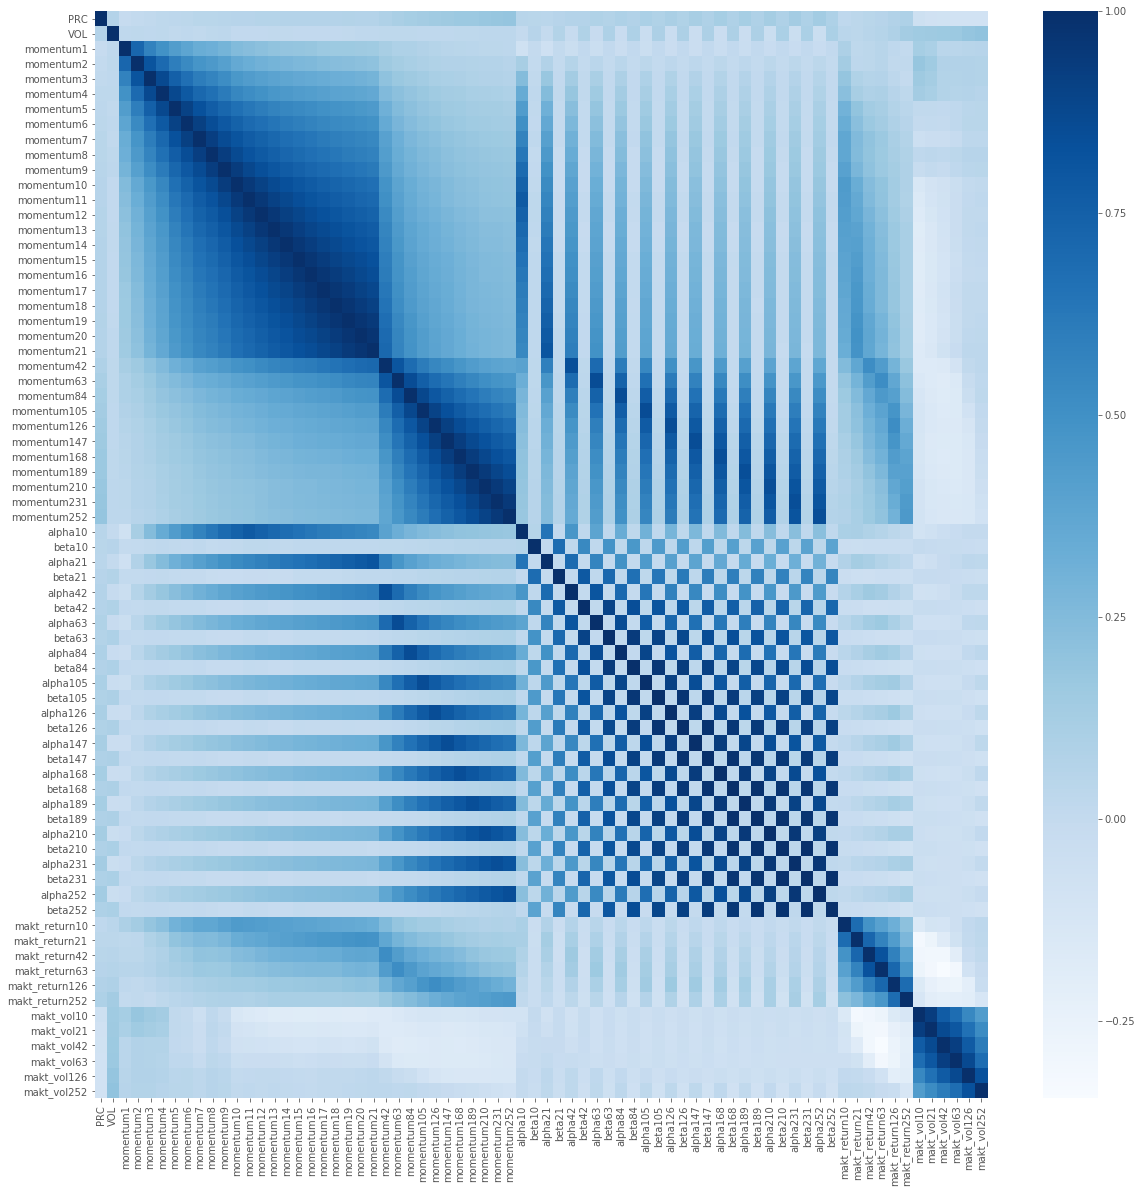

In [12]:
fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111)
ax = sns.heatmap(X_train[feature_all].corr(),\
                 annot=False,annot_kws={'size':6,'weight':'bold'},cmap="Blues")

In [13]:
feature_all1=feature_all[2:]

In [14]:
X_train=X_train[feature_all1]
X_test=X_test[feature_all1]
X_val=X_val[feature_all1]

In [15]:
#base rate
base_rate = np.mean(y_train==1)
base_rate

date      0.00000
TICKER    0.00000
Y         0.49906
dateDT    0.00000
dtype: float64

# Basic Models

# Lasso Models

result from with price and volume

In [16]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
#lmfit = LogisticRegression(C=5).fit(X_train, y_train['Y'])
clf = LogisticRegressionCV(cv=10, random_state=0,penalty='l1', solver='liblinear').fit(X_train, y_train['Y'])
yhat = clf.predict(X_val)
yhatprob = clf.predict_proba(X_val)[:,1]
misratelogit=np.mean(y_val['Y']!=yhat)
misratelogit

In [54]:
top1000_id = np.argsort(yhatprob)[::-1][:1000]
success_in_top_1000 = np.mean(np.array(yhatprob)[top1000_id])
success_in_top_1000

0.6327143839684056

In [62]:
np.where(clf.coef_[0]!=0)[0]

array([0, 1])

result from without price and volume

In [132]:
clf1 = LogisticRegressionCV(cv=10, random_state=0,penalty='l1', solver='liblinear').fit(X_train, y_train['Y'])
yhat1 = clf1.predict(X_val)
yhatprob1 = clf1.predict_proba(X_val)[:,1]
misratelogit1=np.mean(y_val['Y']!=yhat)
misratelogit1

0.5021492372029317

In [133]:
top1000_id = np.argsort(yhatprob1)[::-1][:1000]
success_in_top_1000 = np.mean(np.array(yhatprob1)[top1000_id])
success_in_top_1000

0.5386622584476263

In [134]:
X_train.columns[np.where(clf1.coef_[0]!=0)[0]]

Index(['momentum1', 'momentum2', 'momentum4', 'momentum5', 'momentum6',
       'momentum7', 'momentum8', 'momentum9', 'momentum10', 'momentum11',
       'momentum12', 'momentum13', 'momentum14', 'momentum15', 'momentum17',
       'momentum18', 'momentum19', 'momentum20', 'momentum42', 'momentum63',
       'momentum84', 'momentum105', 'momentum126', 'momentum147',
       'momentum168', 'momentum189', 'momentum210', 'momentum231',
       'momentum252', 'alpha10', 'beta10', 'beta21', 'beta42', 'beta63',
       'beta84', 'beta126', 'beta147', 'beta168', 'beta189', 'beta210',
       'beta252', 'makt_vol10'],
      dtype='object')

# LDA Models

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Define Search Param
search_params = {'n_components': [1,2,3,5,10, 15, 20, 25,30]}

# Init the Model
lda = LinearDiscriminantAnalysis()

# Init Grid Search Class
gsearch1 = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
gsearch1.fit(X_train,y_train['Y'])

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'n_components': [1, 2, 3, 5, 10, 15, 20, 25, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
gsearch1.best_params_

{'n_components': 1}

In [20]:
lda=LinearDiscriminantAnalysis(n_components=gsearch1.best_params_['n_components'])
fitlda=lda.fit(X_train,y_train['Y'])
yhatlda=fitlda.predict(X_val)
#confusion_matrix(y_val['Y'],yhatlda)
misratelda=np.mean(y_val['Y']!=yhatlda)
misratelda

0.5017266753121858

In [21]:
yhatproblda=fitlda.predict_proba(X_val)[:,1]
top1000_id = np.argsort(yhatproblda)[::-1][:1000]
success_in_top_1000 = np.mean(np.array(yhatproblda)[top1000_id])
success_in_top_1000

0.546323268172626

# QDA 
### our hero

In [22]:
# Define Search Param
search_params = {'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}

# Init the Model
qda = QuadraticDiscriminantAnalysis()

# Init Grid Search Class
gsearch2 = GridSearchCV(qda, param_grid=search_params)

# Do the Grid Search
gsearch2.fit(X_train,y_train['Y'])

GridSearchCV(cv=None, error_score=nan,
             estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                                                     store_covariance=False,
                                                     tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
gsearch2.best_params_['reg_param']

0.4

In [31]:
qda=QuadraticDiscriminantAnalysis(reg_param=0.1)
fitqda=qda.fit(X_train,y_train['Y'])
yhatqda=fitqda.predict(X_val)
#confusion_matrix(y_val['Y'],yhatlda)
misrateqda=np.mean(y_val['Y']!=yhatqda)
misrateqda

0.49987614565271243

In [140]:
gsearch2.best_params_['reg_param']

0.1

In [32]:
yhatprobqda=fitqda.predict_proba(X_val)[:,1]
top1000_id = np.argsort(yhatprobqda)[::-1][:1000]
success_in_top_1000 = np.mean(np.array(yhatprobqda)[top1000_id])
success_in_top_1000

0.5008913770610084

# Compute post prob

In [22]:
'''
compute post prob for each stock at each day.
'''

date_test = X_test["date"].unique()
ticker_test = X_test["TICKER"].unique()

post_prob = pd.DataFrame(columns=ticker_test)
for i in date_test:
    #model.predict_proba(X_test[feature_all])
    post_prob.loc[i] = 0
post_prob

,AA,ACAS,ACL,ADBE,ADPT,AES,AHAA,AHC,AHP,AIV,...,PRSP,LHX,VAL,BKR,LIN,NLOK,PEAK,J,TFC,VIAC
1999-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-05-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-06-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-10-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Back test

In [3]:
# use post_prob as input 

In [6]:
df = pd.read_csv("combine_.csv",index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
df.head()

,Unnamed: 0.1,date,CUSIP,RETX,PRC,spindx,sprtrn
0,3330349,19650104,73109510,-0.019204,178.750,84.23,-0.006136
1,2581859,19650104,79345310,-0.012048,30.750,84.23,-0.006136
2,4018766,19650104,44974410,-0.008130,91.500,84.23,-0.006136
3,2566803,19650104,29356110,0.002132,58.750,84.23,-0.006136
4,4023092,19650104,86693010,0.023077,16.625,84.23,-0.006136


In [10]:
y_raw = pd.read_csv("y.csv")
dates = y_raw["date"].unique()
dates

array([19860331, 19860430, 19860530, 19860630, 19860731, 19860829,
       19860930, 19861031, 19861128, 19861231, 19870130, 19870227,
       19870331, 19870430, 19870529, 19870630, 19870731, 19870831,
       19870930, 19871030, 19871130, 19871231, 19880129, 19880229,
       19880331, 19880429, 19880531, 19880630, 19880729, 19880831,
       19880930, 19881031, 19881130, 19881230, 19890131, 19890228,
       19890331, 19890428, 19890531, 19890630, 19890731, 19890831,
       19890929, 19891031, 19891130, 19891229, 19900131, 19900228,
       19900330, 19900430, 19900531, 19900629, 19900731, 19900831,
       19900928, 19901031, 19901130, 19901231, 19910131, 19910228,
       19910328, 19910430, 19910531, 19910628, 19910731, 19910830,
       19910930, 19911031, 19911129, 19911231, 19920131, 19920228,
       19920331, 19920430, 19920529, 19920630, 19920731, 19920831,
       19920930, 19921030, 19921130, 19921231, 19930129, 19930226,
       19930331, 19930430, 19930528, 19930630, 19930730, 19930

In [8]:
grouped = df.groupby("CUSIP")

In [16]:
k=63
for i, j in grouped:
    for m in dates:
        wh = np.where(j["date"]==m)[0]
        if (not wh) or (wh[0] - k < 0):
            continue
        X = j.iloc[wh[0] - k:wh[0], :]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """
